## Surrogate Assisted Evolutionary Algorithms for CNN Hyperparameter Optimization

### Imports

In [1]:
from util import AlexNet, SmallCNN, get_loaders, train_model
from es import *
from surrogates import Surrogates
from copy import deepcopy

import oapackage
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### Create Training Data for Surrogate Models

Create a curated training population using hyperparameters close to default and recommended values

In [2]:
# check if saved file exists
if os.path.exists('curated_training_population.pkl'):
    with open('curated_training_population.pkl', 'rb') as f:
        training_population1 = pickle.load(f)
else:

    # Curated hyperparameters
    lrs = [0.01, 0.001, 0.0001]
    momentums = [0.9, 0.99, 0]
    weight_decays = [0.0005, 0.0001, 0]

    # Create a list of hyperparameter combinations
    hyperparams = []
    for lr in lrs:
        for momentum in momentums:
            for weight_decay in weight_decays:
                hyperparams.append((lr, momentum, weight_decay))

    hyperparams = np.array(hyperparams)

    # create training population from hyperparams
    training_population1 = [Genome(x=hyperparam) for hyperparam in hyperparams]

    # Update fitnesses using multiprocessing on full CNN  
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population1), total=len(training_population1)))

    for i in range(len(training_population1)):
        training_population1[i].valid_acc = results[i][0]
        training_population1[i].train_acc = results[i][1]
        training_population1[i].train_loss = results[i][2]
        training_population1[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('curated_training_population.pkl', 'wb') as f:
        pickle.dump(training_population1, f)

Create a random training population using uniform distributions for each hyperparameter (via default Genome constructor)

In [3]:
# check if saved file exists
if os.path.exists('random_training_population.pkl'):
    with open('random_training_population.pkl', 'rb') as f:
        training_population2 = pickle.load(f)
else:
    
    # Initialize population creation
    training_population2 = [Genome() for _ in range(100)]

    # Update fitnesses using multiprocessing on full CNN   
    with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
        results = list(tqdm(executor.map(fitness, training_population2), total=len(training_population2)))

    # update the population with the results
    for i in range(len(training_population2)):
        training_population2[i].valid_acc = results[i][0]
        training_population2[i].train_acc = results[i][1]
        training_population2[i].train_loss = results[i][2]
        training_population2[i].loss_target_fitness = results[i][3]

    # save the population to a file
    with open('random_training_population.pkl', 'wb') as f:
        pickle.dump(training_population2, f)


Combine population and create visualizations

In [4]:
# combine the two populations
population = training_population1 + training_population2

In [5]:
# mean population validation accuracy
mean_valid_acc = np.mean([genome.valid_acc for genome in population])
print('Mean population validation accuracy: {}'.format(mean_valid_acc))

# mean population training accuracy
mean_train_acc = np.mean([genome.train_acc for genome in population])
print('Mean population training accuracy: {}'.format(mean_train_acc))

# mean population training loss
mean_train_loss = np.mean([genome.train_loss for genome in population])
print('Mean population training loss: {}'.format(mean_train_loss))

# mean population loss target fitness
mean_loss_target_fitness = np.mean([genome.loss_target_fitness for genome in population])
print('Mean population loss target fitness: {}'.format(mean_loss_target_fitness))

# max population validation accuracy
max_valid_acc = np.max([genome.valid_acc for genome in population])
print('Max population validation accuracy: {}'.format(max_valid_acc))

# max population training accuracy
max_train_acc = np.max([genome.train_acc for genome in population])
print('Max population training accuracy: {}'.format(max_train_acc))

# max population training loss
max_train_loss = np.max([genome.train_loss for genome in population])
print('Max population training loss: {}'.format(max_train_loss))

# max population loss target fitness
max_loss_target_fitness = np.max([genome.loss_target_fitness for genome in population])
print('Max population loss target fitness: {}'.format(max_loss_target_fitness))


Mean population validation accuracy: 37.30055016795481
Mean population training accuracy: 39.59373134703148
Mean population training loss: 1.3150466028160936
Mean population loss target fitness: 32.9878969732364
Max population validation accuracy: 73.66999816894531
Max population training accuracy: 88.12999725341797
Max population training loss: 2.327260732650757
Max population loss target fitness: 91.71355498721228


Find and visualize the pareto front

Pareto: 4 optimal values, 4 objects


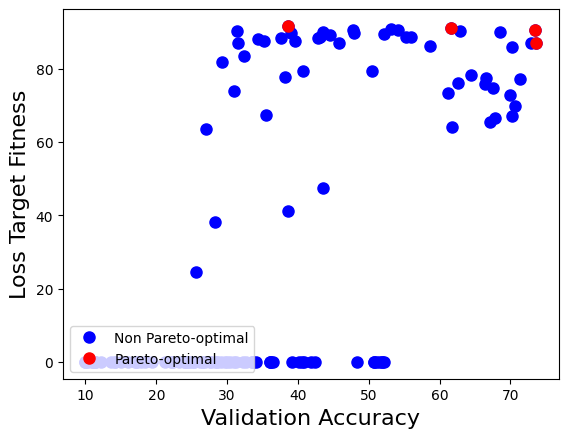

In [6]:
# find the pareto front
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, len(population)):
    w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
    pareto.addvalue(w, ii)
# show the pareto front size 
pareto.show(verbose=1)

# show the pareto front visualization
pareto_front = [population[i] for i in pareto.allindices()]
h=plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
h=plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
_=plt.legend(loc=3, numpoints=1)

### Build and Train Surrogate Models

In our experiments, we will use a support vector regressor (with RBF kernel), a gradient boosting regressor, a gaussian process regressor (with RBF + quadratic Kernels) as our surrogate models. A voting ensemble will be used to combine the predictions of the three models. Because we have two objectives, we will train two models for each surrogate model type.

In [7]:
# initialize the surrogates model
surrogates = Surrogates()

# train the surrogates model
X = np.array([genome.x for genome in population])
y1 = np.array([genome.valid_acc for genome in population])
y2 = np.array([genome.loss_target_fitness for genome in population])
surrogates.train(X, y1, y2, verbose=True)


SVR: Mean Absolute Error for validation accuracy: 9.38 %.
SVR: Mean Absolute Error for loss target fitness: 17.17 %.
Gradient Boosting: Mean Absolute Error for validation accuracy: 7.48 %.
Gradient Boosting: Mean Absolute Error loss target fitness: 22.09 %.
Gaussian Process Regression: Mean Absolute Error for validation accuracy: 8.38 %.
Gaussian Process Regression: Mean Absolute Error for loss target fitness: 18.58 %.
Ensemble: Mean Absolute Error for validation accuracy: 8.23 %.
Ensemble: Mean Absolute Error for loss target fitness: 18.08 %.


In [8]:
# save full trained population to a file. This file will updated anytime a new model is fully trained
fully_trained_population = deepcopy(population)
with open('fully_trained_population.pkl', 'wb') as f:
    pickle.dump(fully_trained_population, f)

### Evolutionary Algorithm: Initial Population and Statistics

In [9]:
# parameters come from es.py
mu=MU
lambda_=LAMBDA
sigma_crossover_rate=SIGMA_CROSSOVER_RATE
x_crossover_rate=X_CROSSOVER_RATE
sigma_mutation_rate=SIGMA_MUTATION_RATE
x_mutation_rate=X_MUTATION_RATE
max_generations=MAX_GENERATIONS
converge_threshold=CONVERGE_THRESHOLD
display_stats=True
retrain_frequency=RETRAIN_FREQUENCY
train_concurrent=TRAIN_CONCURRENT

# Initialize population creation
population = [Genome() for _ in range(mu)]

# Update fitnesses via surrogates model
X = np.array([genome.x for genome in population])
y1_pred, y2_pred = surrogates.predict(X)
for i in range(len(population)):
    population[i].valid_acc = y1_pred[i]
    population[i].loss_target_fitness = y2_pred[i]


# Initialize lists to store generational statistics
generational_valid_acc_max = []
generational_valid_acc_min = []
generational_valid_acc_mean = []

generational_loss_target_max = []
generational_loss_target_min = []
generational_loss_target_mean = []

generational_pareto_fronts = []
generational_diversity = []

generational_surrogate_mae = []

# get statistics about initial generation
vaild_accs = [genome.valid_acc for genome in population]
loss_targets = [genome.loss_target_fitness for genome in population]

generational_valid_acc_max.append(np.max(vaild_accs))
generational_valid_acc_min.append(np.min(vaild_accs))
generational_valid_acc_mean.append(np.mean(vaild_accs))

generational_loss_target_max.append(np.max(loss_targets))
generational_loss_target_min.append(np.min(loss_targets))
generational_loss_target_mean.append(np.mean(loss_targets))

generational_pareto_fronts.append(pareto_front)
generational_diversity.append(get_population_diversity(population))

generational_surrogate_mae.append(surrogates.get_mae())

### Evolutionary Algorithm: Main Loop

In [ ]:
for gen_count in range(max_generations):
    # print generational stats
    if display_stats:
        print(f'{gen_count} {generational_valid_acc_min[-1]:.4f} {generational_valid_acc_mean[-1]:.4f} {generational_valid_acc_max[-1]:.4f}',
                f'{generational_loss_target_min[-1]:.4f} {generational_valid_acc_mean[-1]:.4f} {generational_loss_target_max[-1]:.4f} {generational_diversity[-1]:.4f}')
        
    # container to store new generation
    new_population = []

    # loop to create new generation of size lambda_
    for i in range(lambda_ // 2):
        # Uniform random parent selection
        parent_1_idx = np.random.randint(0, len(population))
        parent_2_idx = np.random.randint(0, len(population))

        parent_1 = deepcopy(population[parent_1_idx])
        parent_2 = deepcopy(population[parent_2_idx])

        # sigma crossover (intermediate recombination)
        sigma_crossover(parent_1, parent_2, crossover_rate=sigma_crossover_rate)

        # sigma mutation 
        sigma_mutate(parent_1, mutation_rate=sigma_mutation_rate)
        sigma_mutate(parent_2, mutation_rate=sigma_mutation_rate)
        
        # x crossover intermediate recombination
        crossover(parent_1, parent_2, crossover_rate=x_crossover_rate)

        # x mutation
        mutate(parent_1, mutation_rate=x_mutation_rate)
        mutate(parent_2, mutation_rate=x_mutation_rate)
            
        # add to new generation
        new_population.append(parent_1)
        new_population.append(parent_2)

    # Update fitnesses via surrogates model
    X = np.array([genome.x for genome in new_population])
    y1_pred, y2_pred = surrogates.predict(X)
    for i in range(len(new_population)):
        new_population[i].valid_acc = y1_pred[i]
        new_population[i].loss_target_fitness = y2_pred[i]
    
    # add new generation to population
    population.extend(new_population)

    # find the pareto front
    pareto=oapackage.ParetoDoubleLong()
    for ii in range(0, len(population)):
        w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
        pareto.addvalue(w, ii)

    pareto_front = [population[ii] for ii in pareto.allindices()]

    # create a new population consisting of the pareto front, the top 10 validation accuracy, and the top 10 loss target fitness
    new_population = [genome for genome in pareto_front]
    num = int((mu - len(pareto_front)) / 2)
    new_population += sorted(population, key=lambda genome: genome.valid_acc, reverse=True)[:num]
    new_population += sorted(population, key=lambda genome: genome.loss_target_fitness, reverse=True)[:num]

    # remove duplicates and set as population
    population = list(set(new_population))

    # every retrain_frequency generations, retrain the surrogates model using full CNN training
    if gen_count > 0 and gen_count % retrain_frequency == 0:

        # Update fitnesses using multiprocessing on full CNN  
        with ProcessPoolExecutor(train_concurrent) as executor:
            results = list(tqdm(executor.map(fitness, population), total=len(population)))
        
        # update fitnesses with results
        for i in range(len(population)):
            population[i].valid_acc = results[i][0]
            population[i].loss_target_fitness = results[i][1]
        
        # update surrogates model
        X = np.array([genome.x for genome in population])
        y1 = np.array([genome.valid_acc for genome in population])
        y2 = np.array([genome.loss_target_fitness for genome in population])
        surrogates.train(X, y1, y2)

        # update pareto front
        pareto=oapackage.ParetoDoubleLong()
        for ii in range(0, len(population)):
            w=oapackage.doubleVector((population[ii].valid_acc, population[ii].loss_target_fitness))
            pareto.addvalue(w, ii)

        pareto_front = [population[ii] for ii in pareto.allindices()]

        # save fully trained population
        fully_trained_population += deepcopy(population)
        with open('fully_trained_population.pkl', 'wb') as f:
            pickle.dump(fully_trained_population, f) 
        

    # get statistics about new population
    vaild_accs = [genome.valid_acc for genome in population]
    loss_targets = [genome.loss_target_fitness for genome in population]

    generational_valid_acc_max.append(np.max(vaild_accs))
    generational_valid_acc_min.append(np.min(vaild_accs))
    generational_valid_acc_mean.append(np.mean(vaild_accs))

    generational_loss_target_max.append(np.max(loss_targets))
    generational_loss_target_min.append(np.min(loss_targets))
    generational_loss_target_mean.append(np.mean(loss_targets))

    generational_pareto_fronts.append(pareto_front)
    generational_diversity.append(get_population_diversity(population))

    generational_surrogate_mae.append(surrogates.get_mae())

    # Check for termination conditions
    # (1) - terminate if generational diversity is below threshold
    if generational_diversity[-1] < converge_threshold :
        if display_stats:
            print(f'Population has converged with generational diversity below threshold of {converge_threshold }')
        break

    # (2) - terminate after max_generations (display message)
    if gen_count == max_generations - 1 and display_stats:
        print('The maximum number of generations has been reached')

# Pickle generational statistics and save to file
with open(f'generational_stats.pkl', 'wb') as f:
    pickle.dump((generational_valid_acc_max, generational_valid_acc_min, generational_valid_acc_mean,
                generational_loss_target_max, generational_loss_target_min, generational_loss_target_mean,
                generational_pareto_fronts,  generational_diversity, generational_surrogate_mae), f)



In [ ]:
len(population)

In [ ]:
h=plt.plot([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population], '.b', markersize=16, label='Non Pareto-optimal')
h=plt.plot([genome.valid_acc for genome in pareto_front], [genome.loss_target_fitness for genome in pareto_front], '.r', markersize=16, label='Pareto-optimal')
plt.xlabel('Validation Accuracy', fontsize=16)
plt.ylabel('Loss Target Fitness', fontsize=16)
_=plt.legend(loc=3, numpoints=1)

In [ ]:
# graph generational statistics
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(generational_valid_acc_max, label='Max')
ax[0].plot(generational_valid_acc_min, label='Min')
ax[0].plot(generational_valid_acc_mean, label='Mean')
ax[0].set_xlabel('Generation', fontsize=16)
ax[0].set_ylabel('Validation Accuracy', fontsize=16)
ax[0].legend(loc=4, numpoints=1)

ax[1].plot(generational_loss_target_max, label='Max')
ax[1].plot(generational_loss_target_min, label='Min')
ax[1].plot(generational_loss_target_mean, label='Mean')
ax[1].set_xlabel('Generation', fontsize=16)
ax[1].set_ylabel('Loss Target Fitness', fontsize=16)
ax[1].legend(loc=4, numpoints=1)


# graph generational diversity
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(generational_diversity)
ax.set_xlabel('Generation', fontsize=16)
ax.set_ylabel('Diversity', fontsize=16)

